In [ ]:
'''
This script runs a simple LSTM model on a single columns (XLocation or YLocation)
and predict k time steps in the future (t+1, t+2...t+k)
The testing activates the droupout in order to generate multiple different outputs
and then calculate the mean and standard deviation
https://fairyonice.github.io/Measure-the-uncertainty-in-deep-learning-models-using-dropout.html
'''


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pickle import dump, load
import sys
import keras
import keras.backend as K
from sklearn.metrics import mean_squared_error,mean_absolute_error
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Activation, Dropout
from keras.models import load_model


Using TensorFlow backend.


In [2]:
class KerasDropoutPrediction(object):
    
    def __init__(self, model):
        self.f = K.function(
            [model.layers[0].input,
             K.learning_phase()],
            [model.layers[-1].output])
        
    def predict(self, x, n_iter=10):
        result = []
        for _ in range(n_iter):
            result.append(self.f([x, 1]))
        result = np.array(result).reshape(n_iter, len(x)).T
        
        #mean = result.mean(axis=0)
        #uncertainty = result.var(axis=0)
        #print("Mean:", mean, "Uncertainty:", uncertainty)
        #mean = np.mean(result)
        #std = np.std(result)
        
        return result
        
        


In [3]:
def plot_prediction(x, y_true, y_pred):
    """Plots the predictions.

    Arguments
    ---------
    x: Input sequence of shape (input_sequence_length,
        dimension_of_signal)
    y_true: True output sequence of shape (input_sequence_length,
        dimension_of_signal)
    y_pred: Predicted output sequence (input_sequence_length,
        dimension_of_signal)
    """
    label1 = "Seen (past) values"
    label2 = "True future values"
    label3 = "Predictions"
    
    plt.figure(figsize=(12, 3))
    plt.plot(range(len(x)),x, "o--b", label=label1)
    plt.plot(range(len(x), len(x) + len(y_true) ), y_true, "x--b", label=label2)
    plt.plot(range(len(x), len(x) + len(y_pred)),y_pred, "o--y", label=label3)
    
    plt.legend(loc='best')
    plt.title("Predictions v.s. true values")
    plt.show()


In [4]:
def plot_prediction_ranges(x, y_true, y_pred, y_lower, y_upper, std, std_label):
    """Plots the predictions.

    Arguments
    ---------
    x: Input sequence of shape (input_sequence_length,
        dimension_of_signal)
    y_true: True output sequence of shape (input_sequence_length,
        dimension_of_signal)
    y_pred: Predicted output sequence (input_sequence_length,
        dimension_of_signal)
    """
    label1 = "Seen (past) values"
    label2 = "True future values"
    label3 = "Predictions"
    label4 = "Lower bound"
    label5 = "Upper bound"
    
    title = "Predictions v.s. true values ("+ str(std) \
            + " std. deviation, "+ std_label+"% )"
    
    plt.figure(figsize=(12, 3))
    plt.plot(range(len(x)),x, "o--b", label=label1)
    plt.plot(range(len(x), len(x) + len(y_true) ), y_true, "x--b", label=label2)
    plt.plot(range(len(x), len(x) + len(y_pred)),y_pred, "o--y", label=label3)
    
    plt.plot(range(len(x), len(x) + len(y_pred)),y_lower, "+--r", label=label4)
    plt.plot(range(len(x), len(x) + len(y_pred)),y_upper, "*--r", label=label5)
    
    plt.legend(loc='best')
    plt.title(title)
    plt.show()    


In [5]:
def size_per_targets(data):
    #print("Total: ", data.shape[0])
    sizes = data.groupby(['id', 'file_id']).size()
    #print(sizes)
    #print(type(sizes))
    #print("Total:",sum(list(sizes)))

    return list(sizes)


In [6]:
def generate_input_data(data, sizes, train_len, target_seq):
    targets = len(sizes)
    start = 0
    sequences = []
    X = []
    y = []
    
    for i, size in enumerate(sizes):
        print("Chunk", i+1)
        end = start + size
        print("Size of block %d, Range: %d-%d" % (size, start, end))
        temp_df = data.iloc[start:end]
        
        values = temp_df.iloc[:,-target_seq].values
        for i in range(train_len, len(values)):
            seq = values[i-train_len:i]
            
            sequences.append(seq)
                   
        # update start
        start = start + size
    
    sequences = np.array(sequences)    
    print("[INFO] Sequences generated:", len(sequences))
    
    X = sequences[:,:-target_seq]
    y = sequences[:,-target_seq]

    return X, y



# MAIN   


## Load the data

In [7]:
filename = 'data/AllData.csv'
data = pd.read_csv(filename)
print(data.shape)
print(list(data.columns))


(500050, 18)
['id', 'file_id', 'Pn', 'Pe', 'h', 'Va', 'Phi', 'Theta', 'Chi', 'Psi', 'Vg', 'Azimuth', 'Elevation', 'XPixel', 'YPixel', 'ZValue', 'XLocation', 'YLocation']


## Generate the input data


#### Defining Parameters


In [8]:
column_of_interest = 'XLocation'
input_seq = 10
target_seq = 1      # 
predict_k = 3       # predict k time steps in the future
train_len = input_seq + target_seq
target = 0     # 0 = AllTargets

test_percentage = 0.2
rand_test = True

dropout = .4
batch_size = 64
neurons = 64
epochs = 5

k_test_instances = 50      # number of randomly chosen instances to test
p_instances_to_plot = 3
n_results = 1000         # Number of predictions for the dropout

model_filename = 'models/model_lstm_'+column_of_interest+"_"+str(input_seq)+"_timesteps_dropout.h5"
scaler_filename = 'models/model_lstm_'+column_of_interest+"_"+str(input_seq)+"_timesteps_dropout"


## Generate input data


In [9]:
# -1 is All data, else is the target id

if target != 0:
    input_data = data[data['id'] == target]
else:
    input_data = data

# Take only the column of interest
input_data = input_data[['id', 'file_id', column_of_interest]]
columns = input_data.columns

# We need to generate the sequences based on the id and file_id
sizes = size_per_targets(input_data)
X, y = generate_input_data(input_data, sizes, train_len, target_seq)


Chunk 1
Size of block 10001, Range: 0-10001
Chunk 2
Size of block 10001, Range: 10001-20002
Chunk 3
Size of block 10001, Range: 20002-30003
Chunk 4
Size of block 10001, Range: 30003-40004
Chunk 5
Size of block 10001, Range: 40004-50005
Chunk 6
Size of block 10001, Range: 50005-60006
Chunk 7
Size of block 10001, Range: 60006-70007
Chunk 8
Size of block 10001, Range: 70007-80008
Chunk 9
Size of block 10001, Range: 80008-90009
Chunk 10
Size of block 10001, Range: 90009-100010
Chunk 11
Size of block 10001, Range: 100010-110011
Chunk 12
Size of block 10001, Range: 110011-120012
Chunk 13
Size of block 10001, Range: 120012-130013
Chunk 14
Size of block 10001, Range: 130013-140014
Chunk 15
Size of block 10001, Range: 140014-150015
Chunk 16
Size of block 10001, Range: 150015-160016
Chunk 17
Size of block 10001, Range: 160016-170017
Chunk 18
Size of block 10001, Range: 170017-180018
Chunk 19
Size of block 10001, Range: 180018-190019
Chunk 20
Size of block 10001, Range: 190019-200020
Chunk 21
Siz

### Getting train, test data

In [10]:

# If we select the train and test randomly
if rand_test:
    print("Randomly picking train, test dataset")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_percentage, 
                                                        shuffle=False, random_state=42)
# Else, select the last % part as testing
else:
    print("Train, test split based on percentage")
    test_size = int(X.shape[0] * test_percentage)
    train_size = int(X.shape[0] - test_size)
    print("Train size:", train_size)
    X_train = X[:train_size, :]
    X_test = X[train_size:, :]
    
    y_train = y[:train_size]
    y_test = y[train_size:]    

print("X Train size=", X_train.shape[0])
print("X Test size=",X_test.shape[0])
print("y Train size=", y_train.shape[0])
print("y Test size=",y_test.shape[0])


Randomly picking train, test dataset
X Train size= 399600
X Test size= 99900
y Train size= 399600
y Test size= 99900


### Scale the Input Data


In [11]:
# fit the values between 0 and 1
scaler_object = MinMaxScaler()

scaler_object.fit(X_train)

scaled_X_train =  scaler_object.transform(X_train)
scaled_X_test =  scaler_object.transform(X_test)

train_X = scaled_X_train.reshape((scaled_X_train.shape[0], 1, scaled_X_train.shape[1]))
test_X = scaled_X_test.reshape((scaled_X_test.shape[0], 1, scaled_X_test.shape[1]))


#print(train_X.shape, y_train.shape, test_X.shape, y_test.shape)

train_X = train_X.reshape((scaled_X_train.shape[0], scaled_X_train.shape[1], 1))

test_X = test_X.reshape((scaled_X_test.shape[0], scaled_X_test.shape[1], 1))
print("(Instances,Sequence,Features)")
print(train_X.shape, y_train.shape, test_X.shape, y_test.shape)



(Instances,Sequence,Features)
(399600, 10, 1) (399600,) (99900, 10, 1) (99900,)


## Create the LSTM model


In [20]:
### If it is already saved then do not run it again, it takes time
# design network
model = Sequential()
model.add(LSTM(neurons, input_shape=(train_X.shape[1], train_X.shape[2]), return_sequences=True))
model.add(Dropout(dropout))
model.add(LSTM(neurons))
model.add(Dropout(dropout))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()
# fit network
history = model.fit(train_X, y_train, epochs=epochs, batch_size=batch_size, 
                    validation_data=(test_X, y_test), verbose=2, shuffle=False)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 10, 64)            16896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 49,985
Trainable params: 49,985
Non-trainable params: 0
_________________

KeyboardInterrupt: 

### Plot the loss

In [38]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

print(history.history.keys())


NameError: name 'history' is not defined

### Save the model and scaler


In [ ]:
print(model_filename)
model.save(model_filename)
print(scaler_filename)
dump(scaler_object, open(scaler_filename, 'wb'))


### Load the model


In [13]:
print("Loading the model:", model_filename)
model = load_model(model_filename)
print("Loading the scaler:", scaler_filename)
scaler_object = load(open(scaler_filename, 'rb'))


Loading the model: models/model_lstm_XLocation_10_timesteps_dropout.h5
Loading the scaler: models/model_lstm_XLocation_10_timesteps_dropout


## Make predictions with dropout
As it will take a lot of time do the prediction for all the test set
I pick a random number of test instances

### Pick some random indices

In [16]:
indices = np.random.choice(range(test_X.shape[0]), replace=False, size=k_test_instances)
print(indices)

 

[85783 41264  5984 88263 36455 97556 14733 47411 87655 70406 57250 94049
 94469 25881 95669 13371 91640 48210 47205 83017 85225 52840 23497 88865
 92602 57798 84953 87162 27078 16462 79343  5084  1697 34662   842 27590
 95539 30270 34586 42851 99874 78105 93090 95968 46596 35984 86912  6929
 68375 97846]


In [17]:

kdp = KerasDropoutPrediction(model)

y_true = []
y_hat = []
y_hat_std = []
for i, index in enumerate(indices):
    x_test = test_X[index]
    y_true.append(y_test[index])
    result = kdp.predict([x_test], n_results)
    #print(result.flatten())
    #print(result.shape)
    yhat_mean = np.mean(result)
    yhat_std = np.std(result)
    print(i+1, '\t', index, '\tMean:', yhat_mean, 'Std:', yhat_std, 'y',y_test[index])
    y_hat.append(yhat_mean)
    y_hat_std.append(yhat_std)

print(y_true)
print(len(y_true))
print(y_hat)
print(len(y_hat))
print(y_hat_std)
print(len(y_hat_std))


1 	 85783 	Mean: 246.84956 Std: 13.770571 y 250.05
2 	 41264 	Mean: 213.03514 Std: 10.90018 y 215.7
3 	 5984 	Mean: 145.36028 Std: 3.9594882 y 149.9
4 	 88263 	Mean: 231.08478 Std: 12.274898 y 232.65
5 	 36455 	Mean: 267.4222 Std: 16.372719 y 274.55
6 	 97556 	Mean: 55.04716 Std: 8.719207 y 67.35
7 	 14733 	Mean: 184.81688 Std: 8.093656 y 187.35
8 	 47411 	Mean: 145.47444 Std: 3.91952 y 149.9
9 	 87655 	Mean: 247.14584 Std: 14.36716 y 250.05
10 	 70406 	Mean: 170.41656 Std: 6.383856 y 174.3
11 	 57250 	Mean: 429.74915 Std: 31.821032 y 450.05
12 	 94049 	Mean: 145.49872 Std: 3.9633987 y 149.9
13 	 94469 	Mean: 145.30434 Std: 4.0420494 y 149.9
14 	 25881 	Mean: 327.86945 Std: 23.44652 y 345.5
15 	 95669 	Mean: 145.35196 Std: 3.9202425 y 149.9
16 	 13371 	Mean: 177.85158 Std: 7.138628 y 180.55
17 	 91640 	Mean: 233.12552 Std: 12.964193 y 237.0
18 	 48210 	Mean: 132.72269 Std: 2.7884684 y 137.2
19 	 47205 	Mean: 145.35382 Std: 3.8918135 y 149.9
20 	 83017 	Mean: 245.68297 Std: 14.774485 y 

### Calculating Prediction Ranges (lower and upper bounds)


In [18]:
def get_ranges(y_hat, y_hat_std, num_stds=1):
    y_hat_lowers = []
    y_hat_uppers = []

    for i in range(len(y_hat)):
        point = y_hat[i]
        std = y_hat_std[i]
        lower = point - (num_stds * std)
        upper = point + (num_stds * std)
        
        y_hat_lowers.append(lower)
        y_hat_uppers.append(upper)
        
    
    return y_hat_uppers, y_hat_lowers


With std deviation

In [35]:
std_dev = 3
std_dev_labels = {1:'0.68', 2:'0.95', 3:'0.997'}


In [36]:
print("Results with %d standad deviation" % std_dev)
y_hat_uppers, y_hat_lowers = get_ranges(y_hat, y_hat_std, std_dev)
print("Upper:\t", y_hat_uppers)
print("Mean:\t",y_hat)
print("Truth:\t", y_true)
print("Lower:\t",y_hat_lowers)



Results with 3 standad deviation
Upper:	 [288.16127586364746, 245.73568058013916, 157.2387397289276, 267.9094705581665, 316.54036712646484, 81.2047815322876, 209.09784603118896, 157.23300123214722, 290.24732303619385, 189.5681324005127, 525.2122402191162, 157.38891434669495, 157.43048477172852, 398.20900535583496, 157.1126868724823, 199.2674617767334, 272.01809883117676, 141.08809185028076, 157.0292613506317, 290.0064220428467, 290.1623525619507, 336.7960205078125, 290.33885192871094, 230.58883666992188, 247.20389938354492, 526.8678092956543, 289.5239887237549, 286.1308183670044, 337.0993061065674, 260.54765033721924, 402.21286392211914, 157.03085041046143, 269.7738857269287, 360.2483139038086, 217.49666690826416, 310.04512310028076, 157.14272546768188, 178.82956981658936, 364.2664794921875, 233.9484748840332, 66.04813003540039, 403.7842273712158, 215.2180347442627, 153.28027200698853, 157.8507056236267, 290.91261196136475, 288.26623344421387, 106.30986404418945, 156.92464637756348, 69

## Evaluate the model
from random samples


In [21]:
# make a prediction
#print("test_X shape", test_X.shape)
#yhat = model.predict(test_X)
# calculate RMSE
rmse = np.sqrt(mean_squared_error(y_true, y_hat))
print('Test RMSE: %.3f' % rmse)
mae = np.sqrt(mean_absolute_error(y_true, y_hat))
print('Test MAE: %.3f' % mae)


Test RMSE: 8.790
Test MAE: 2.563


## Comparing results

In [75]:
# Picked k random test instances
#t_X = test_X.reshape(test_X.shape[0], test_X.shape[1])
##t_X = test_X.reshape(test_X.shape[0], 1, test_X.shape[1])


In [22]:
print(indices)

plot_indices = np.random.choice(list(indices), replace=False, size=p_instances_to_plot)
print(plot_indices)

plot_indices_idx = []
for p in plot_indices:
    idx = list(indices).index(p)
    plot_indices_idx.append(idx)
    
print(plot_indices_idx)


[85783 41264  5984 88263 36455 97556 14733 47411 87655 70406 57250 94049
 94469 25881 95669 13371 91640 48210 47205 83017 85225 52840 23497 88865
 92602 57798 84953 87162 27078 16462 79343  5084  1697 34662   842 27590
 95539 30270 34586 42851 99874 78105 93090 95968 46596 35984 86912  6929
 68375 97846]
[88865 70406 47205]
[23, 9, 18]


### Plot some tests

88865
70406
47205


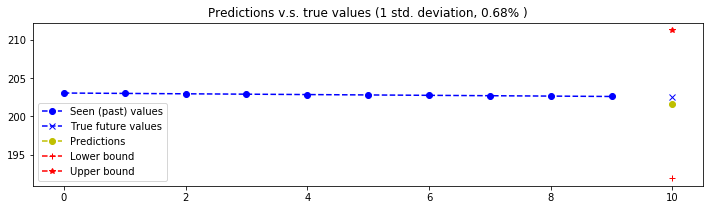

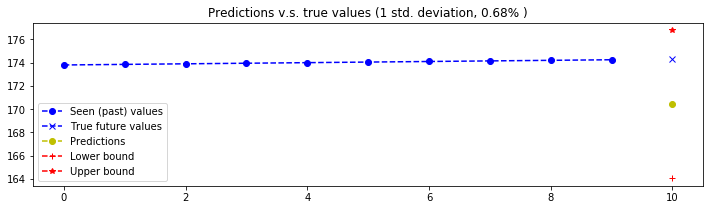

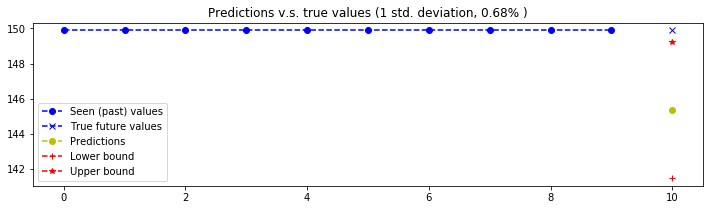

In [23]:
#indices = np.random.choice(range(t_X.shape[0]), replace=False, size=3)
for i, index in enumerate(plot_indices):
    print(index)
    x_test = test_X[index]
    x_test = x_test.reshape(x_test.shape[1], x_test.shape[0])
    test_X_rescaled = scaler_object.inverse_transform(x_test)
    y_idx = list(indices).index(index)
    
    plot_prediction_ranges(test_X_rescaled[0], [y_test[index]], 
                           [y_hat[y_idx]], [y_hat_lowers[y_idx]],[y_hat_uppers[y_idx]],
                           std_dev, std_dev_labels[std_dev])



## Predicting k steps in the future


In [24]:
all_predictions = []
all_deviations = []
for index in plot_indices:
    print("~"*50)
    print("~"*50)
    print("Predictions for index:", index)
    x_test = np.asarray([test_X[index]])    
    input = x_test
    print("input shape", input.shape)
    
    predictions = []
    std_deviations = []
    for i in range(predict_k):
        print("Pred ", i+1)    
        print("Input shape:", input.shape)
        window = input.reshape(x_test.shape[0], x_test.shape[1])
        ##print("Window")
        ##print(window)
        ##print("window shape",window.shape)
        
        # This will convert the values to Location values
        window_rescaled = scaler_object.inverse_transform(window)
        print("Window rescaled")
        print(window_rescaled)
        print("window rescaled shape:",window_rescaled.shape)
        
        result = kdp.predict(input, n_results)
        #print(result.flatten())
        #print(result.shape)
        yhat_mean = np.mean(result)
        yhat_std = np.std(result)
        
        #yhat = model.predict(input)
        yhat = yhat_mean
        print("Pred ", i+1, ":", yhat)
        
        #predictions.append(yhat[0][0])    
        predictions.append(yhat)
        print('yhat', yhat)
        ##print(type(yhat))
        ##print(type(window_rescaled))

        std_deviations.append(yhat_std)
        
        input = np.append(window_rescaled[:,1:], yhat)
        print("New window:", input)
        print("New window shape", input.shape)
 
        input = input.reshape(1, input.shape[0], window.shape[0])
        ##print("New new input shape:", input.shape)
        ##print(input)
        # This will convert the location values to scaled values
        
        input = input.reshape(1, input.shape[1])
        input = scaler_object.transform(input)
        ##print("New scaled input")
        ##print(input)
        ##print("New scaled input shape", input.shape)
        
        input = input.reshape(1, input.shape[1], window.shape[0])
        ##print("input shape",input.shape)
        print("#" * 50)
        
    print(predictions)
    print(std_deviations)
    
    all_predictions.append(predictions)
    all_deviations.append(std_deviations)
print()
print(all_predictions)
print(all_deviations)
      

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Predictions for index: 88865
input shape (1, 10, 1)
Pred  1
Input shape: (1, 10, 1)
Window rescaled
[[203.05 203.   202.95 202.9  202.85 202.8  202.75 202.7  202.65 202.6 ]]
window rescaled shape: (1, 10)
Pred  1 : 201.77322
yhat 201.77322
New window: [203.         202.95       202.9        202.85       202.8
 202.75       202.7        202.65       202.6        201.77322388]
New window shape (10,)
##################################################
Pred  2
Input shape: (1, 10, 1)
Window rescaled
[[203.         202.95       202.9        202.85       202.8
  202.75       202.7        202.65       202.6        201.77322388]]
window rescaled shape: (1, 10)
Pred  2 : 201.01384
yhat 201.01384
New window: [202.95       202.9        202.85       202.8        202.75
 202.7        202.65       202.6        201.77322388 201.01383972]
New window shape (10,)
#########################################

### Get the ranges


In [37]:
all_uppers = []
all_lowers = []
all_means = []

print("Results with %d standard deviations" % std_dev)
for i, index in enumerate(plot_indices):
    print(i)
    y_hats = all_predictions[i]
    std_devs = all_deviations[i]
    #print(y_hats)
    #print(std_devs)
    y_uppers = []
    y_lowers = []
    y_means = []
    for j in range(len(y_hats)):
        yhat = [y_hats[j]]
        ystd = [std_devs[j]]
        #print('yhat:',yhat)
        #print('ystd:',ystd)
        
        y_hat_uppers, y_hat_lowers = get_ranges(yhat, ystd, std_dev)
        
        print("Upper:\t", y_hat_uppers[0])
        print("Mean:\t",yhat[0])
        print("Truth:\t", y_test[index])
        print("Lower:\t",y_hat_lowers[0])
        print()
        y_uppers.append(y_hat_uppers[0])
        y_lowers.append(y_hat_lowers[0])
        y_means.append(yhat[0])
    print()
    
    all_uppers.append(y_uppers)
    all_lowers.append(y_lowers)
    all_means.append(y_means)


Results with 3 standard deviations
0
Upper:	 230.46513843536377
Mean:	 201.77322
Truth:	 202.55
Lower:	 173.08130931854248

Upper:	 230.6855230331421
Mean:	 201.01384
Truth:	 202.55
Lower:	 171.34215641021729

Upper:	 229.19958019256592
Mean:	 201.19028
Truth:	 202.55
Lower:	 173.18097400665283


1
Upper:	 190.10921573638916
Mean:	 170.57231
Truth:	 174.3
Lower:	 151.03540706634521

Upper:	 190.02508354187012
Mean:	 170.50171
Truth:	 174.3
Lower:	 150.97833442687988

Upper:	 189.6380410194397
Mean:	 170.3453
Truth:	 174.3
Lower:	 151.05257177352905


2
Upper:	 157.87892770767212
Mean:	 145.50047
Truth:	 149.9
Lower:	 133.12201833724976

Upper:	 157.2211856842041
Mean:	 145.04106
Truth:	 149.9
Lower:	 132.86093711853027

Upper:	 157.35186290740967
Mean:	 144.95921
Truth:	 149.9
Lower:	 132.5665636062622




### Print the ranges

In [39]:
print(all_uppers)
print(all_means)
print(all_lowers)


[[230.46513843536377, 230.6855230331421, 229.19958019256592], [190.10921573638916, 190.02508354187012, 189.6380410194397], [157.87892770767212, 157.2211856842041, 157.35186290740967]]
[[201.77322, 201.01384, 201.19028], [170.57231, 170.50171, 170.3453], [145.50047, 145.04106, 144.95921]]
[[173.08130931854248, 171.34215641021729, 173.18097400665283], [151.03540706634521, 150.97833442687988, 151.05257177352905], [133.12201833724976, 132.86093711853027, 132.5665636062622]]


## Plot future predictions with boundaries


88865
70406
47205


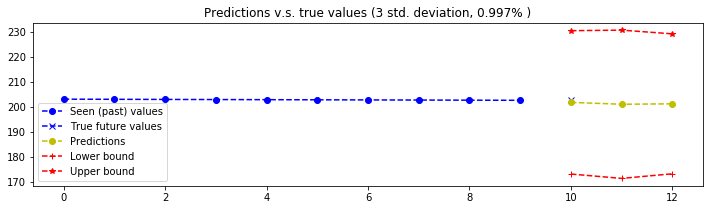

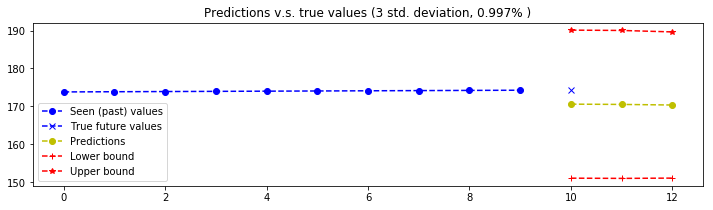

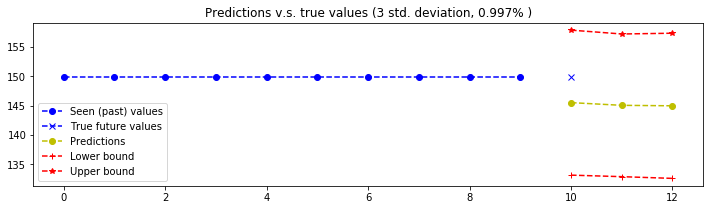

In [38]:
for i, index in enumerate(plot_indices):
    print(index)
    x_test = test_X[index]
    x_test = x_test.reshape(x_test.shape[1], x_test.shape[0])
    test_X_rescaled = scaler_object.inverse_transform(x_test)
    y_idx = list(indices).index(index)
    
    plot_prediction_ranges(test_X_rescaled[0], [y_test[index]], 
                           all_means[i], all_lowers[i],
                           all_uppers[i],
                           std_dev, std_dev_labels[std_dev])



        

